## Fitting

Fitting time series to CARMA models using __EzTao__ can be done in just one line. We demonstrate how to quickly get reliable best-fit CARMA parameters using the built-in fitting functions. However, you are not bound to the built-in functions; you can use the CARMA kernels to compute the likelihood and combine that with other optimizers to get the best-fit parameters, which we will also demonstrate.

### The built-in fitting functions

There are three built-in fitting functions included in the [eztao.ts.carma_fit](../python/ts.rst#module-eztao.ts.carma_fit) module:

- `drw_fit`: Fit input time series to a DRW model
- `dho_fit`: Fit input time series to a DHO/CARMA(2,1) model
- `carma_fit`: Fit input time series to an arbitrary CARMA model (must specifiy p and q order).

The first two should be used if you want to fit data to DRW or DHO, and the last one can be used to fit data to any CARMA models.  Next, let's take a look at the `carma_fit` function. We will start by simulating a CARMA process and fit it using `carma_fit`, then compare the best-fit parameters to the ones used in simulation.

In [1]:
import numpy as np
from eztao.carma import DHO_term
from eztao.ts import gpSimRand
from eztao.ts import carma_fit

# define a DHO kernel
dho_kernel = DHO_term(np.log(0.04), np.log(0.0027941), np.log(0.004672), 
                      np.log(0.0257))

# simulate a DHO process
nLC = 1
t, y, yerr = gpSimRand(dho_kernel, 10, 365*10, 200, nLC=nLC)

In [2]:
%%time
# fit
best_fit = carma_fit(t, y, yerr, 2, 1, n_iter=10)

print(f'True input DHO parameters:{np.exp(dho_kernel.get_parameter_vector())}')
print(f'Best-fit DHO parameters: {best_fit}')
print('----------------------------------------------------')

True input DHO parameters:[0.04      0.0027941 0.004672  0.0257   ]
Best-fit DHO parameters: [0.02553668 0.00258195 0.00358801 0.02715611]
----------------------------------------------------
CPU times: user 725 ms, sys: 4.76 ms, total: 730 ms
Wall time: 730 ms


From the cell above, we can see that it took ~ 1 second (if not shorter) to obtain a best-fit that is quite close to the input. The robust performance is a result of a combination of many carefully chosen fitting components, most importantly the $\mathit{celerite}$ backend for fast evaluation of the likelihood function and a powerful global optimizer for efficient exploration of the parameter space. However, we want to note that to better fit time series to models with orders higher than CARMA(2,1), more robust global optimizer might be needed. In the last section, we will show how to choose your own optimizer to obtain best-fit parameters. 

<div class="alert alert-info">

Note

The built-in fitting functions use a modified version of the general purpose `scipy.optimize.minimize` optimizer with the 'L-BFGS-B' method. The modification is simply running the optimizing algorithm many more times and each with a different initialization, as a result, the possibility of stuck in a local minima is reduced significantly. That said, it is still possible to get stuck in a local minima. Two apparent solutions are: increasing the number of optimizers used simutaneously through setting the `n_iter` argument or using a more robust optimizer. 

</div>

#### Fitting to CARMA models that are higher than CARMA(2,1)

<div class="alert alert-warning">

Warning

The CARMA parameter space (specified by the defining stochastic differential equation) is no longer continous (meaning giving a stationary process) when p > 2! Read the text below for more details.

</div>

More care must be taken when fitting time series to CARMA models that are higher than CARMA(2,1). The reason is that for CARMA models more complex than CARMA(2,1), the vanilla CARMA parameter space is no longer continuous; in other words, a random set of CARMA parameters may not produce a stable CARMA process, thus cannot return a valid likelihood during the fitting process. The solution to this problem is to sample from a space spanned by the coefficients of the AR/MA characteristic polynomials in the factored form. To learn more about this property of CARMA, please check out the papers linked in [Introduction](./00_Introduction.ipynb).

With __EzTao__, you don't need to worry about the transformation between these two spaces. `carma_fit` will automatically fit in the polynomial space when the p order is greater than 2.

In [3]:
from eztao.carma import CARMA_term

# simulate a CARMA(3,0) process
carma_kernel = CARMA_term(np.log([3, 3.189, 0.05]), np.log([0.5]))
t2, y2, yerr2 = gpSimRand(carma_kernel, 50, 365*10, 1000, log_flux=False)

Text(0.5, 1.0, 'Simulated CARMA(3,0) process')

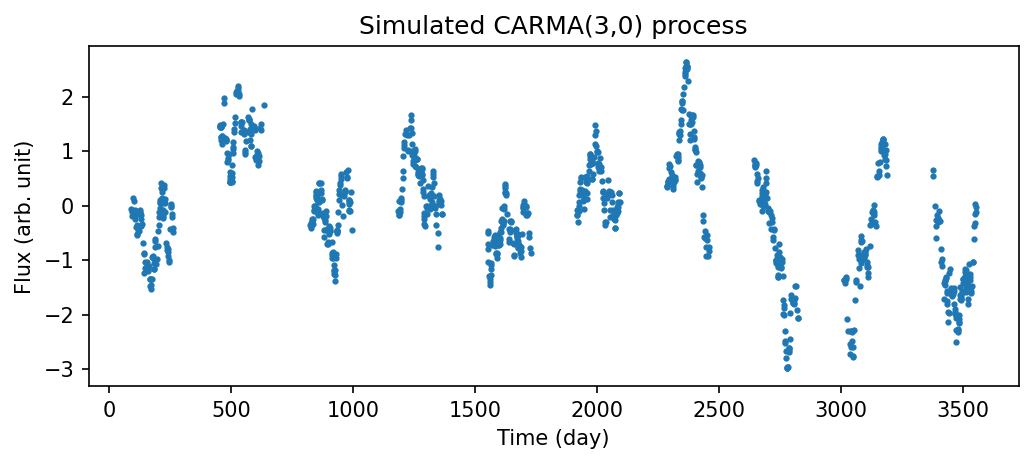

In [4]:
import matplotlib.pyplot as plt

# plot the simulated process
fig, ax = plt.subplots(1,1, dpi=150, figsize=(8,3))
ax.errorbar(t2, y2, yerr2, fmt='.', markersize=4)
ax.set_xlabel('Time (day)')
ax.set_ylabel('Flux (arb. unit)')
ax.set_title('Simulated CARMA(3,0) process')

Now, let's fit the simulated time series to a CARMA(3,0) model.

In [5]:
best_fit2 = carma_fit(t2, y2, yerr2, 3, 0, n_iter=10)
print(f'True input CARMA(3,0) parameters:{np.exp(carma_kernel.get_parameter_vector())}')
print(f'Best-fit CARMA(3,0) parameters: {best_fit2}')
print('----------------------------------------------------')

/Users/weixiang/Projects/EzTao/env/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


True input CARMA(3,0) parameters:[3.    3.189 0.05  0.5  ]
Best-fit CARMA(3,0) parameters: [3.12656134 3.41348722 0.03995773 0.52539742]
----------------------------------------------------


<div class='alert alert-info'>

Note

We stress that getting accurate/reliable best-fit parameters (without running long MCMC) for CARMA processe that are more complex that CARMA(2,1) might require more robust optimizers than what's currently implemented. Our experience also tells us that the higher the order of the CARMA model that we are fitting to the higher the S/N is needed in order to obtain accurate/reliable best-fit.

</div>

### Use your own optimizer
Using your own optimizer is very straight forward. All you need to do is use your optimizer to generate parameter proposals and use the CARMA kernels from __EzTao__ to compose a likelihood function. Caution should be taken when fitting to models that are higher than CARMA(2,1) for the reasons that I explained above, and we will reemphasize the below as well. We will use the steps shown in $\mathit{celerite}$'s [online tutorials](https://celerite.readthedocs.io/en/stable/tutorials/first/) to illustrate this process. 

#### Fit models that are equallly or less complex than CARMA(2,1)
The process to fit time series to those three models is no different than what's shown in $\mathit{celerite}$'s tutorials. You can compose your own likelihood function, ``neg_log_like``, like what's been demonstrated, __EzTao__ also provides a likelihood function---``neg_param_ll``, where 'll' stands for log likelihood.

In [6]:
from celerite import GP
from eztao.ts import neg_param_ll
from eztao.ts import sample_carma
from scipy.optimize import minimize

In [7]:
# randomly generate some DHO parameters and use it to define a DHO kernel/GP
dho_ar, dho_ma = sample_carma(2, 1)
dho_kernel_fit = CARMA_term(np.log(dho_ar), np.log(dho_ma))
gp = GP(dho_kernel_fit, mean=np.median(y))
gp.compute(t, yerr)
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -8618.849190738398


In [8]:
# optimize to find DHO parameters giving the highest log likelihood
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_param_ll, initial_params, bounds=bounds, method="L-BFGS-B", args=(y, gp))
gp.set_parameter_vector(r.x)

In [9]:
print(f'True input DHO parameters:{np.exp(dho_kernel.get_parameter_vector())}')
print(f'Best-fit DHO parameters: {np.exp(r.x)}')
print(f'Final log likelihood: {gp.log_likelihood(y)}')

True input DHO parameters:[0.04      0.0027941 0.004672  0.0257   ]
Best-fit DHO parameters: [0.02553671 0.00258195 0.00358802 0.02715607]
Final log likelihood: 155.35201077789307


#### Fitting to models that are more complex than CARMA(2,1)
Fitting time series to higher-order models will need to change `neg_param_ll` to `neg_fcoeff_ll`. If you would like to compose your own likelihood function, you need to use `gp.kernel.set_log_fcoeffs(params)` instead of `gp.set_parameter_vector(params)` for updating parameters of the CARMA kernel. The current implementation doesn't allow combining CARMA kernels with other kernels (e.g., jitter or a trend), but future versions, especially after switching the backend to $\mathit{celerite2}$, we will look at adding this feature.

In [10]:
from eztao.ts import carma_log_fcoeff_init, carma_log_param_init, neg_fcoeff_ll

# initialize a CARMA kernel with paramters chose randomly in the regular space.
rand_params = carma_log_param_init(3, 0)
carma_kernel_fit = CARMA_term(np.array(rand_params[:3]), np.array(rand_params[3:]))

# initialize GP
gp2 = GP(carma_kernel_fit, mean=np.median(y2))

# update kernel with valid parameters (by drawing the polynomial space)
init_coeff = carma_log_fcoeff_init(3, 0)
gp2.kernel.set_log_fcoeffs(init_coeff)
gp2.compute(t2, yerr2)
print("Initial log likelihood: {0}".format(gp2.log_likelihood(y2)))

Initial log likelihood: -117180.60899239732


In [11]:
# fit

# giving a 'valid' boundary is often a good practice, EzTao's built-in 
# fitting functions handle this internally as long as the time unit is day
ARbounds = [(-8, 8)] * 3
MAbounds = [(-5, 5)] * (0 + 1)
bounds = ARbounds + MAbounds

initial_params = init_coeff
r2 = minimize(neg_fcoeff_ll, initial_params, bounds=bounds, method="L-BFGS-B", args=(y2, gp2))
gp2.kernel.set_log_fcoeffs(r2.x)

In [12]:
print(f'True input DHO parameters:{np.exp(carma_kernel.get_parameter_vector())}')
print(f'Best-fit DHO parameters: {np.exp(gp2.get_parameter_vector())}')
print(f'Final log likelihood: {gp2.log_likelihood(y2)}')

True input DHO parameters:[3.    3.189 0.05  0.5  ]
Best-fit DHO parameters: [776.74592756 914.09987611  11.79245922 148.4131591 ]
Final log likelihood: 683.4801815646722


<div class="alert alert-info">
    
Note
    
- We can only do as good as the likelihood landscape allows (unless you can come up with a useful prior landscape). 
- The quality of the likelihood landscape (regarding smoothness and the ability to recover true parameters) depends on the properties of the input time series, such as sampling and the level of measurement noise relative the RMS amplitude of the underlying CARMA process.
    
</div>